In [1]:
import sqlite3 as sql
import datetime
class ParkingArea:

    def __init__(self,parking_area_name : str,total_capacity : int, currently_filled = 0 ) -> None:

        # Parameter initialization
        self.name = parking_area_name
        self.total_capacity = total_capacity
        self.currently_filled = currently_filled
        self.avg_occupancy = 0
        self.avg_new_visiting = 0
        self.dates = set()
        self.daily_slot_average = {}
        self.daily_slot_count = {}
        self.slot_unavailable_count = {}
        self.daily_new_visiting = {}
        self.date_format = "%Y-%m-%d"
        self.current_date = datetime.datetime.now()
        

        
        # Database Connetion Initialization
        self._db_name = parking_area_name +  ".db"
        self.parked_table_name = parking_area_name+ "_parked"
        self.record_table_name = parking_area_name+ "_record"
        self.customer_table_name = parking_area_name+ "_customer"

        # Database Creation
        self._db = sql.connect(self._db_name)
        
        # Database Cursor Declaration
        self.db_cur = self._db.cursor()
        self.db_cur.execute(f"CREATE TABLE IF NOT EXISTS {self.parked_table_name} (Car_Number VARCHAR , Date VARCHAR, In_Time VARCHAR)")
        self.db_cur.execute(f"CREATE TABLE IF NOT EXISTS {self.record_table_name} (Car_Number VARCHAR , Date VARCHAR, In_Time VARCHAR , Out_Time VARCHAR)")
        self.db_cur.execute(f"CREATE TABLE IF NOT EXISTS {self.customer_table_name} (Car_Id INTEGER, Car_Number VARCHAR)")
    
    def customer_data_entry(self, vehicle_id : int, vehicle_number : str) -> bool:

        #Adding Customer's Id and Car Number
        try:
            cmd = f'''INSERT INTO {self.customer_table_name} VALUES ( "{vehicle_id}", "{vehicle_number}")'''
            self.db_cur.execute(cmd)
            return True

        except:
            print("Entry failed")
            return False
        

    def entry(self, vechile_id : str, date : str, In_Time : str) -> bool:
        '''
            Adds the car to Parked Table
        '''
        flag = 0
        try:
            # Initialize date in dictionary
            if date not in self.slot_unavailable_count:
                self.slot_unavailable_count[date] = 0
            if date not in self.daily_new_visiting:
                self.daily_new_visiting[date] = 0

            #Check if existing customer or new-comer 
            check_cmd = f"SELECT * FROM {self.customer_table_name} WHERE Car_Number = '{vechile_id}'"
            res = self.db_cur.execute(check_cmd)
            count = res.fetchone()
            if not count:
                self.daily_new_visiting[date] += 1


            

            if self.currently_filled < self.total_capacity:
                cmd = f'''INSERT INTO {self.parked_table_name} VALUES ("{vechile_id}","{date}","{In_Time}")'''
                self.db_cur.execute(cmd)
                self.currently_filled+=1
                
                if date not in self.daily_slot_count:
                    self.daily_slot_count[date] = 1
                else:
                    self.daily_slot_count[date] += 1

                curr_date = datetime.datetime.strptime(date,self.date_format)
                if self.current_date == datetime.datetime.now():
                    self.current_date = curr_date
                else:
                    # if self.current_date != curr_date:
                    #     self.daily_average(date)
                    self.current_date = curr_date
                self.daily_average(date)

                self.dates.add(date)
            else:
                self.slot_unavailable_count[date] += 1
                print("No free parking slots available")
                return False
            return True
        
        except:
            print("Entry Failed")
            return False
    
    
    def exit(self, vechile_id : str , Out_Time : str) -> bool:
        '''
            Remove the car from the Parked Database and Its to the Entry Records 
        '''
        try:
            select_cmd = f"SELECT * FROM {self.parked_table_name} WHERE Car_Number = '{vechile_id}'"
            car_data_cur   = self.db_cur.execute(select_cmd)
            vechile_id,date,In_Time = car_data_cur.fetchone()
            
            push_data = f'''INSERT INTO {self.record_table_name} VALUES ("{vechile_id}","{date}","{In_Time}","{Out_Time}")'''
            self.db_cur.execute(push_data)

            cmd = f"DELETE FROM {self.parked_table_name} WHERE Car_Number = '{vechile_id}'"
            self.db_cur.execute(cmd)
            self.currently_filled-=1

            return True
        except:
            print("Exit Failed")
            return False
        
    def daily_average(self,cur_date : str):
        if cur_date not in self.daily_slot_average:
            self.daily_slot_average[cur_date] = 0
        ct = self.daily_slot_count[cur_date]
        avg = (ct/self.total_capacity)*100
        self.daily_slot_average[cur_date] = avg



In [2]:
import pandas as pd
sample_data = pd.read_csv('entry_exit data/data_3.csv')
customer_data = pd.read_csv('customer_data/customer_data.csv')

In [3]:

vehicle_id = sample_data['vehicle_id']
vehicle_number = sample_data['vehicle_license_plate']
entry_time_data = sample_data['entry_time']
exit_time_data = sample_data['exit_time']
date_data = sample_data['date']

cust_id = customer_data['car_id']
cust_number = customer_data['car_number']
print(len(cust_id))

20


In [15]:
# from datetime import datetime
# print(type(date_data[0]))
# print(date_data[0])
# date_format = "%Y-%m-%d"
# curr_date = datetime.strptime(date_data[0],date_format)
# print(type(curr_date))
# print(curr_date)

In [4]:
sample_area = ParkingArea('Sample_mall4',20)
sample_area.parked_table_name

'Sample_mall4_parked'

In [18]:
#QUICK COMMANDS FOR RESETTING TABLE
del_cmd = f"DELETE FROM {sample_area.parked_table_name}"
del_cmd2 = f"DELETE FROM {sample_area.record_table_name}"
sample_area.db_cur.execute(del_cmd)
sample_area.db_cur.execute(del_cmd2)
sample_area.currently_filled = 0


In [5]:
for i in range(0,len(cust_id)):
    id = cust_id[i]
    number = cust_number[i]
    sample_area.customer_data_entry(id,number)

In [6]:
for i in range(0,len(vehicle_id)):   
    id = vehicle_id[i] 
    number = vehicle_number[i]
    entry = entry_time_data[i]
    exit = exit_time_data[i]
    dt = date_data[i]

    cmd = f"SELECT * FROM {sample_area.parked_table_name} WHERE Car_Number = '{number}'"
    check = sample_area.db_cur.execute(cmd).fetchall()

    if len(check) == 0:
        ret = sample_area.entry(number,dt,entry)
        print(f"Vehicle Id = {id}  {ret}  ")
    else:
        ret = sample_area.exit(number,exit)
    
    #Just for dummy dataset
    if i == len(vehicle_id-1):
        sample_area.daily_average(dt)
    
    
    

    

Vehicle Id = 1  True  
Vehicle Id = 2  True  
Vehicle Id = 3  True  
Vehicle Id = 4  True  
Vehicle Id = 5  True  
Vehicle Id = 6  True  
Vehicle Id = 7  True  
Vehicle Id = 8  True  
Vehicle Id = 9  True  
Vehicle Id = 10  True  
Vehicle Id = 11  True  
Vehicle Id = 12  True  
Vehicle Id = 13  True  
Vehicle Id = 14  True  
Vehicle Id = 15  True  
Vehicle Id = 16  True  
Vehicle Id = 17  True  
Vehicle Id = 18  True  
Vehicle Id = 19  True  
Vehicle Id = 20  True  
No free parking slots available
Vehicle Id = 21  False  
No free parking slots available
Vehicle Id = 22  False  
Vehicle Id = 24  True  
No free parking slots available
Vehicle Id = 25  False  
No free parking slots available
Vehicle Id = 26  False  
Vehicle Id = 45  True  
Vehicle Id = 47  True  
Vehicle Id = 48  True  
Vehicle Id = 51  True  
Vehicle Id = 52  True  
Vehicle Id = 53  True  
Vehicle Id = 54  True  
Vehicle Id = 55  True  
Vehicle Id = 56  True  
Vehicle Id = 57  True  
Vehicle Id = 58  True  
Vehicle Id = 

In [7]:
print(sample_area.db_cur.execute(f"SELECT * FROM {sample_area.record_table_name}").fetchall())


[('DL-14-GH-5678', '2024-07-03', '18:45', '17:30'), ('KA-01-AB-1234', '2024-07-01', '09:00', '11:45'), ('DL-05-CD-5678', '2024-07-01', '11:15', '14:45'), ('MH-12-EF-9101', '2024-07-01', '14:00', '18:15'), ('AP-31-GH-2345', '2024-07-01', '15:45', '18:30'), ('TN-22-IJ-6789', '2024-07-01', '17:30', '20:30'), ('KA-02-KL-3456', '2024-07-01', '19:00', '21:45'), ('DL-06-MN-7890', '2024-07-02', '09:15', '11:15'), ('KA-03-UV-2345', '2024-07-02', '11:45', '15:45'), ('DL-08-GH-5678', '2024-07-02', '14:30', '17:15'), ('MH-13-OP-1234', '2024-07-02', '16:00', '19:00'), ('TN-23-ST-9101', '2024-07-02', '18:30', '21:45'), ('KA-04-EF-1234', '2024-07-02', '20:00', '23:00'), ('DL-07-WX-6789', '2024-07-02', '21:15', '23:45'), ('MH-14-YZ-9101', '2024-07-03', '10:00', '12:30'), ('AP-33-AB-3456', '2024-07-03', '12:15', '15:00'), ('TN-24-CD-7890', '2024-07-03', '13:30', '18:00'), ('KA-05-GH-6789', '2024-07-03', '15:15', '20:00'), ('MH-21-IJ-9101', '2024-07-03', '17:00', '22:30'), ('KA-07-AB-1234', '2024-07-04'

In [8]:
print(sample_area.daily_slot_count["2024-07-01"])
print(sample_area.daily_slot_average["2024-07-01"])
print(sample_area.daily_slot_average["2024-07-01"])

6
30.0
30.0


In [9]:
sample_area.slot_unavailable_count["2024-07-11"]
print("Total slots not available over the weeks = ", sum(sample_area.slot_unavailable_count.values()))

Total slots not available over the weeks =  10


In [10]:
id = "AP-35-MN-9101"
check_cmd = f"SELECT * FROM {sample_area.customer_table_name} WHERE Car_Number = '{id}'"
res = sample_area.db_cur.execute(check_cmd)
count = res.fetchone()
if count:
    print("present")

present


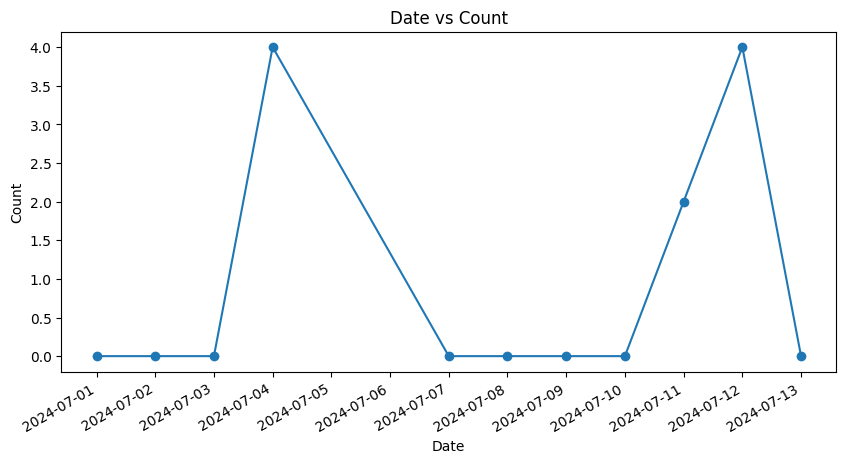

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Sample data dictionary
data = sample_area.slot_unavailable_count


# Convert the dictionary to lists of dates and counts
dates = [datetime.strptime(date, '%Y-%m-%d') for date in data.keys()]
counts = list(data.values())

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(dates, counts, marker='o')

# Format the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Date vs Count')

# Show the plot
plt.show()
